## Hubmap 铜牌（伪金牌）模型复现
### 整体思路：
1 在模型encoder后加入ASPP处理，并在decoder中加入CBAM的attention处理，取得了0.929的dice。并取出decoder不同分辨率的特征层进行各层像素粗融合hypercolumns的来克服边界像素分类不准的问题，训练后达到0.938的dice coefficient。  
2 后处理中采用训练了一个分类网络对切割后的图片是否含有肾小球进行分类，并对测试后肾小球像素百分比设置阈值去除掉像素占比少的肾小球图片(可能是噪音）最后融合FPN, DeepLabV3+等多个模型的方式达到了0.948的dice。

In [68]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

#### CBAM 模块

In [69]:
class ChannelAttentionModule(nn.Module):
    def __init__(self, in_channel, reduction):
        super().__init__()
        self.global_maxpool = nn.AdaptiveMaxPool2d(1)
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channel, in_channel//reduction, kernel_size=1, bias=False),
            # nn.BatchNorm2d(in_channel//reduction),
            nn.ReLU(inplace=False),
            nn.Conv2d(in_channel//reduction, in_channel, kernel_size=1, bias=False),
            # nn.BatchNorm2d(in_channel),
        )
        self.sigmoid = nn.Sigmoid()
    def forward(self, inputs):
        x1 = self.global_maxpool(inputs)
        x2 = self.global_avgpool(inputs)
        x1 = self.fc(x1)
        x2 = self.fc(x2)
        x = self.sigmoid(x1+x2)
        return x * inputs
    
class SpatialAttentionModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, inputs):
        # torch.max 返回第一个是最大的数，第二个是所在索引
        x1,_ = torch.max(inputs, dim=1, keepdim=True)
        x2 = torch.mean(inputs, dim=1, keepdim=True)
        x = torch.cat([x1, x2], dim=1)
        x = self.conv(x)
        x = self.sigmoid(x)
        return x * inputs
    
class CBAM(nn.Module):
    def __init__(self, in_channel, reduction):
        super().__init__()
        self.cam = ChannelAttentionModule(in_channel, reduction)
        self.sam = SpatialAttentionModule()
    def forward(self, inputs):
        x = self.cam(inputs)
        x = self.sam(x)
        return x

#### ASPP 模块

In [70]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.mean = nn.AdaptiveAvgPool2d((1,1))
        self.conv1 = nn.Conv2d(in_channels, out_channels, 1, 1)
        self.ato1 = nn.Conv2d(in_channels, out_channels, 1, 1)
        self.ato6 = nn.Conv2d(in_channels, out_channels, 3, 1, padding=6, dilation=6)
        self.ato12 = nn.Conv2d(in_channels, out_channels, 3, 1, padding=12, dilation=12)
        self.ato18 = nn.Conv2d(in_channels, out_channels, 3, 1, padding=18, dilation=18)
        self.conv_adjust = nn.Conv2d(out_channels*5, out_channels, 1, 1)

    def forward(self, x):
        size = x.shape[2:]
        x1 = self.mean(x)
        x1 = self.conv1(x1)
        x1 = F.upsample(x1, size=size, mode='bilinear')
        
        x2 = self.ato1(x)
        x3 = self.ato6(x)
        x4 = self.ato12(x)
        x5 = self.ato18(x)
        
        out = self.conv_adjust(torch.cat([x1, x2, x3, x4, x5], dim=1))
        return out

In [71]:
# model = ASPP(256, 128)
# test = torch.rand(4, 256, 224, 224)
# model(test).shape

#### se-resnest结构
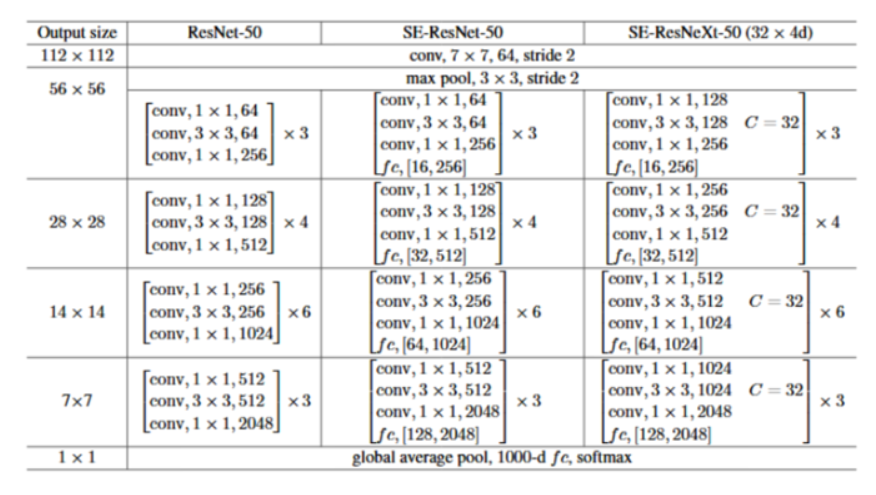

In [72]:
class SEResnextBottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None, group=32):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, 3, stride, padding=1, groups=group, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes*self.expansion, 1, 1)
        self.bn3 = nn.BatchNorm2d(planes*self.expansion)
        self.globalpool = nn.AdaptiveAvgPool2d((1,1))
        self.squeeze = nn.Conv2d(planes*self.expansion, planes*self.expansion//16, 1, 1, bias=False)
        self.expand = nn.Conv2d(planes*self.expansion//16, planes*self.expansion, 1, 1, bias=False)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out)) 
        se = self.globalpool(out)
        se = self.expand(self.relu(self.squeeze(se)))
        se = self.sigmoid(se)
        out = se*out
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [73]:
class Resnet(nn.Module):
    def __init__(self, block, layers, num_classes=100):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # 四个layer
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes*block.expansion, 1, stride),
                nn.BatchNorm2d(planes*block.expansion)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes*block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [87]:
# model = Resnet(SEResnextBottleneck, [3,4,23,3])
# test = torch.rand(4, 3, 224, 224)
# model

#### 搭建Unet+CBAM+ASPP+hypercolumns（粗分类）

In [75]:
class Decoderblock(nn.Module):
    def __init__(self, in_channels, out_channels, upsample):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.upsample = nn.Sequential()
        if upsample:
            self.upsample.add_module('upsample',nn.Upsample(scale_factor=2, mode='nearest'))
        self.conv1 = nn.Conv2d(in_channels, in_channels, 3, 1, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, out_channels, 3, 1, padding=1)
        self.cbam = CBAM(out_channels, reduction=16)
        self.conv3 = nn.Conv2d(in_channels, out_channels, 1, 1)
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.relu(self.bn1(inputs))
        x = self.upsample(x)
        x = self.relu(self.bn2(self.conv1(x)))
        x = self.cbam(self.conv2(x))
        x += self.conv3(self.upsample(inputs))
        return x

In [89]:
class Unet_SeResNext(nn.Module):
    def __init__(self, resolution, clfhead):
        super().__init__()
        # h, w = resolution
        self.clf = clfhead
        
        model = Resnet(SEResnextBottleneck, [3,4,23,3])
        self.encoder0 = nn.Sequential(model.conv1, model.bn1, model.relu)  # (*, 64, w//2, h//2)
        self.encoder1 = nn.Sequential(model.maxpool, model.layer1)# (*, 256, w//4, h//4)
        self.encoder2 = model.layer2 # (*, 512, w//8, h//8)
        self.encoder3 = model.layer3 # (*, 1024, w//16, h//16)
        self.encoder4 = model.layer4 # (*, 2048, w//32, h//32)
        
        self.center = ASPP(2048, 512)
        
        self.decoder4 = Decoderblock(512+2048, 64, True)
        self.decoder3 = Decoderblock(64+1024, 64, True)
        self.decoder2 = Decoderblock(64+512, 64, True)
        self.decoder1 = Decoderblock(64+256, 64, True)
        self.decoder0 = Decoderblock(64, 64, True)
        
        self.upsample4 = nn.Upsample(scale_factor=16, mode='bilinear', align_corners=True)
        self.upsample3 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.upsample2 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.final_conv = nn.Sequential(
            nn.Conv2d(320,64, 3, 1, padding=1),
            nn.ReLU(True),
             nn.Conv2d(64,1, 1, 1)
        )
        
    def forward(self, inputs):
        x0 = self.encoder0(inputs) 
        # print(x0.shape)
        x1 = self.encoder1(x0)
        # print(x1.shape)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        # print(x3.shape)
        x4 = self.encoder4(x3)
        # print(x4.shape)
        
        y5 = self.center(x4)
        y4 = self.decoder4(torch.cat([x4, y5], dim=1))
        # print(y4.shape)
        y3 = self.decoder3(torch.cat([x3, y4], dim=1))
        y2 = self.decoder2(torch.cat([x2, y3], dim=1))
        y1 = self.decoder1(torch.cat([x1, y2], dim=1))
        y0 = self.decoder0(y1)
        # print(y0.shape, y1.shape,y2.shape,y3.shape,y4.shape)
        y4 = self.upsample4(y4)
        y3 = self.upsample3(y3)
        y2 = self.upsample2(y2)
        y1 = self.upsample1(y1)
        # print(y0.shape, y1.shape,y2.shape,y3.shape,y4.shape)
        y = torch.cat([y0, y1, y2, y3, y4], dim=1)
        y = self.final_conv(y)
        return y    

In [90]:
a = torch.rand(4, 3, 64, 64)
model = Unet_SeResNext(_, True)
model(a).shape

torch.Size([4, 1, 64, 64])